# Setup

In [1]:
import json
import os
import sys
import pickle
import warnings

sys.path.append('..')

import pandas as pd
import numpy as np

from flaml import AutoML

from utils import read_csv_non_utf, preprocess_data, ratios_to_DI_cats, get_train_test_split
from performance_reports import get_regression_report, get_classification_report

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']

data_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)

In [3]:
# Reading in data as a pandas dataframe
ben_lop2019 = read_csv_non_utf(data_path)

In [4]:
# Getting the shared basic train/test split
train_size = 0.7
idxs = get_train_test_split(len(ben_lop2019), train_size = train_size)

# Pre-processing data
pp_data = preprocess_data(ben_lop2019, include_indicators = False, standardize = True, log_trans_cont = False,
                          polynomial_features = 0, train_test_idxs = idxs)

#  splitting the actual dataset into train/test sets
train_data, test_data = pp_data.loc[idxs['train']], pp_data.loc[idxs['test']]

#  putting into the format that FLAML wants
X_train, X_test = train_data.drop(columns = 'ratio').values, test_data.drop(columns = 'ratio').values
y_train, y_test = train_data['ratio'].values, test_data['ratio'].values

# AutoML

I am using Microsoft's [`flaml`](https://github.com/microsoft/FLAML) for AutoML, which supports a range of models for regression: 
- [Light Gradient Boosting Machine (LGBM)](https://github.com/microsoft/LightGBM),
- [Extreme Gradient Boosting (XGBoost)](https://github.com/dmlc/xgboost),
- [Random Forest (RF)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor),
- [Extra Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html),
- [Histogram Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor),
- [Categorical Boosting (CatBoost)](https://github.com/catboost/catboost),
- [$k$-Nearest Neighbors ($k$-NN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html).

Noticeably, linear models and neural networks are missing from the mix, but we may be able to use `flaml` to perform [efficient hyperparameter tuning](https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#guidelines-on-tuning-a-custom-estimator) on these using `sklearn` or `PyTorch` implementations.

In [5]:
# Initialize the auto ML instance
automl = AutoML()

# Specify paramaters
automl_settings = {
    'time_budget' : 60,  # in seconds
    'metric' : 'mae',
    'task' : 'regression',
    'log_file_name' : 'mammals_direct_regression.log'
}

# Train with labeled input data
automl.fit(X_train = X_train, y_train = y_train, **automl_settings)

[flaml.automl.logger: 05-20 16:35:13] {1680} INFO - task = regression
[flaml.automl.logger: 05-20 16:35:13] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 05-20 16:35:13] {1789} INFO - Minimizing error metric: mae
[flaml.automl.logger: 05-20 16:35:13] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 05-20 16:35:13] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-20 16:35:14] {2345} INFO - Estimated sufficient time budget=6911s. Estimated necessary time budget=49s.
[flaml.automl.logger: 05-20 16:35:14] {2392} INFO -  at 0.7s,	estimator lgbm's best error=0.9137,	best estimator lgbm's best error=0.9137
[flaml.automl.logger: 05-20 16:35:14] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-20 16:35:14] {2392} INFO -  at 1.3s,	estimator lgbm's best error=0.9137,	best estimator lgbm's best error=0.9137
[flaml.automl.logger: 05-20 16:35:14] {2219} INFO - i

CLASSIFICATION PERFORMANCE
--------------------------
              precision    recall  f1-score   support

         low       0.73      0.76      0.75       560
      medium       0.31      0.61      0.41       207
        high       0.00      0.00      0.00       218

    accuracy                           0.56       985
   macro avg       0.35      0.46      0.39       985
weighted avg       0.48      0.56      0.51       985

Balanced accuracy: 45.53%


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

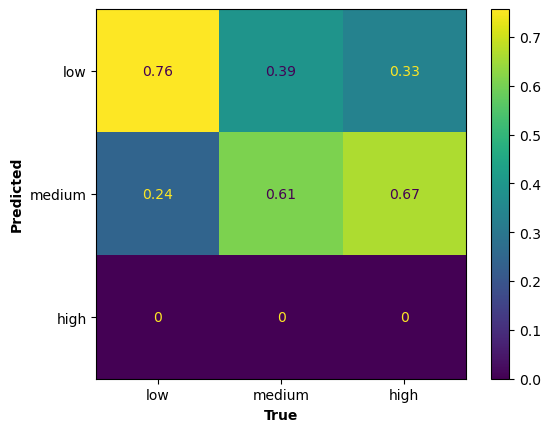


REGRESSION PERFORMANCE
----------------------
Mean absolute error: 0.902
Median absolute error: 0.319
Root mean squared error: 3.228
Root median squared error: 0.319


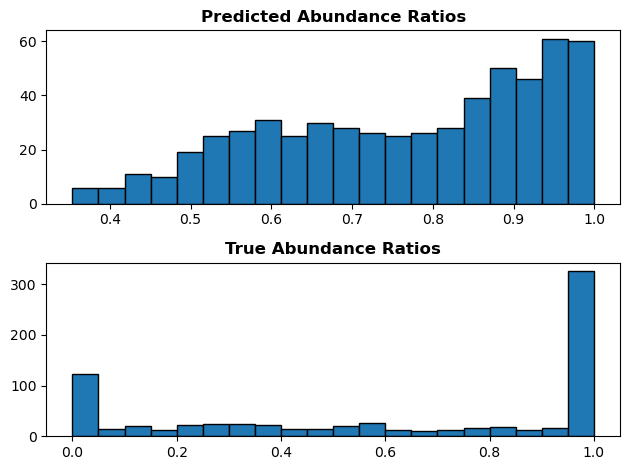

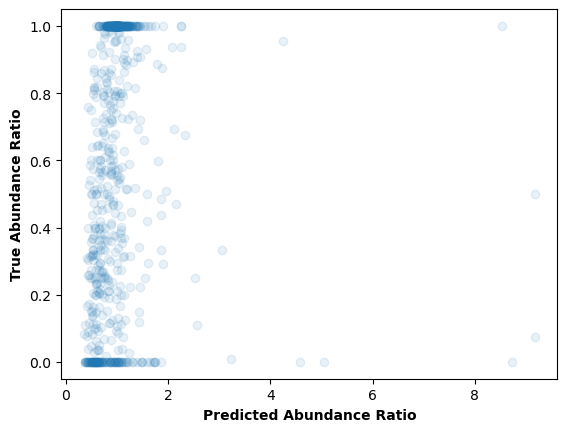

In [7]:
# Getting regression and classification true vs. predicted
pred_ratios = automl.predict(X_test)
test_ratios = y_test

pred_DI_cats = ratios_to_DI_cats(pred_ratios)
true_DI_cats = ratios_to_DI_cats(test_ratios)

# Getting classification and regression reports
print('CLASSIFICATION PERFORMANCE')
print('--------------------------')
get_classification_report(true_DI_cats, pred_DI_cats, printout = True)
print()

print('REGRESSION PERFORMANCE')
print('----------------------')
get_regression_report(test_ratios, pred_ratios, printout = True)